<a href="https://colab.research.google.com/github/toarstn92/fast_api_app/blob/main/image_scene_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download / unzip intel-image-classification syntax

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip

In [41]:
# img property

import cv2
building = cv2.imread("seg_train/seg_train/buildings/10006.jpg")
building.shape

(150, 150, 3)

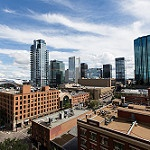

In [42]:
# view image

from google.colab.patches import cv2_imshow

cv2_imshow(building)

In [43]:
# all training directory paths

import os

class_folder_paths = ["seg_train/seg_train/" + x for x in os.listdir("seg_train/seg_train")]
class_folder_paths

['seg_train/seg_train/sea',
 'seg_train/seg_train/mountain',
 'seg_train/seg_train/buildings',
 'seg_train/seg_train/street',
 'seg_train/seg_train/glacier',
 'seg_train/seg_train/forest']

In [44]:
# total images per directory

for class_folder_path in class_folder_paths:
  print("{0}: ".format(class_folder_path), len(os.listdir(class_folder_path)))

seg_train/seg_train/sea:  2274
seg_train/seg_train/mountain:  2512
seg_train/seg_train/buildings:  2191
seg_train/seg_train/street:  2382
seg_train/seg_train/glacier:  2404
seg_train/seg_train/forest:  2271


In [45]:
train_dir = "seg_train/seg_train/"
val_dir = "seg_test/seg_test/"

In [46]:
# image generator for training and validation data
# iterating onver images in batches of batch_size
# image can also be augumented by tweaking parameters

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(horizontal_flip=True)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size=(150, 150),
                                                     color_mode="rgb",
                                                     batch_size=32,
                                                     class_mode="categorical",
                                                     shuffle=True)

val_data_gen = ImageDataGenerator()

val_generator = val_data_gen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [47]:
# all labels in training data

labels = train_generator.class_indices
class_mapping = dict((v, k) for k, v in labels.items())
class_mapping

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [48]:
# model of choice

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense

before_mobilenet = Sequential([Input((150, 150, 3)),
                               Lambda(preprocess_input)])

mobilenet = MobileNetV2(input_shape=(150, 150, 3),
                        include_top=False) # dont include final layer

after_mobilenet = Sequential([GlobalAveragePooling2D(), # shring dimensionally
                              Dropout(0.3),
                              Dense(6, activation="softmax")]) # class probabilities

model = Sequential([before_mobilenet, mobilenet, after_mobilenet])

In [49]:
# compile model

from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.00001)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [50]:
# model workflow

model.build(((None, 150, 150, 3)))

before_mobilenet.summary()
mobilenet.summary()
after_mobilenet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 150, 150, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864       

In [51]:
# fit the model to training data image generator

from tensorflow.keras.callbacks import ModelCheckpoint

train_cb = ModelCheckpoint("model/", save_best_only=True) # make a chaeck point

model.fit(train_generator, validation_data=val_generator, callbacks=[train_cb], epochs=7)

Epoch 1/7
439/439 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.6306

439/439 [==============================] - 79s 169ms/step - loss: 1.0123 - accuracy: 0.6306 - val_loss: 0.6647 - val_accuracy: 0.7757
Epoch 2/7
439/439 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8441

439/439 [==============================] - 81s 185ms/step - loss: 0.4517 - accuracy: 0.8441 - val_loss: 0.4063 - val_accuracy: 0.8580
Epoch 3/7
439/439 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8751

439/439 [==============================] - 81s 185ms/step - loss: 0.3584 - accuracy: 0.8751 - val_loss: 0.3148 - val_accuracy: 0.8943
Epoch 4/7
439/439 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8938

439/439 [==============================] - 78s 177ms/step - loss: 0.3026 - accuracy: 0.8938 - val_loss: 0.2691 - val_accuracy: 0.9067
Epoch 5/7
439/439 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9081

439/439 [==============================] - 72s 164ms/step - loss: 0.2650 - accuracy: 0.9081 - val_loss: 0.2564 - val_accuracy: 0.9123
Epoch 6/7
439/439 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9160

439/439 [==============================] - 79s 180ms/step - loss: 0.2376 - accuracy: 0.9160 - val_loss: 0.2371 - val_accuracy: 0.9157
Epoch 7/7
439/439 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9183

439/439 [==============================] - 71s 162ms/step - loss: 0.2250 - accuracy: 0.9183 - val_loss: 0.2325 - val_accuracy: 0.9160


In [62]:
# zip model for download

!zip -r model.zip model/

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: model/variables/variables.index (deflated 79%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 96%)


In [ ]:
# convert model to lightweight tensorflowlite for easier usage

import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model

In [53]:
# save tensorflowlite version of model

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

In [54]:
# read in test images to predict

import cv2
import numpy as np


inp1 = cv2.imread("seg_test/seg_test/forest/20056.jpg")
inp2 = cv2.imread("seg_test/seg_test/forest/20062.jpg")

inps = [inp1, inp2]
inps

[array([[[ 37,  41,  30],
         [ 61,  71,  59],
         [ 77,  96,  81],
         ...,
         [ 95, 122,  96],
         [ 90, 120,  91],
         [ 93, 123,  94]],
 
        [[ 79,  92,  78],
         [ 50,  69,  54],
         [ 47,  77,  58],
         ...,
         [ 87, 113,  90],
         [ 89, 115,  91],
         [ 78, 104,  80]],
 
        [[ 29,  61,  42],
         [ 18,  56,  34],
         [ 52, 100,  74],
         ...,
         [ 88, 106,  93],
         [ 94, 113,  98],
         [ 90, 109,  94]],
 
        ...,
 
        [[111, 117, 124],
         [112, 118, 125],
         [ 97, 101, 106],
         ...,
         [108, 111, 116],
         [126, 125, 134],
         [ 86,  86,  92]],
 
        [[ 89,  92, 100],
         [ 92,  95, 103],
         [101, 104, 109],
         ...,
         [ 99, 101, 109],
         [118, 117, 127],
         [ 94,  93, 102]],
 
        [[122, 125, 133],
         [133, 136, 144],
         [129, 132, 137],
         ...,
         [144, 145, 155],
  

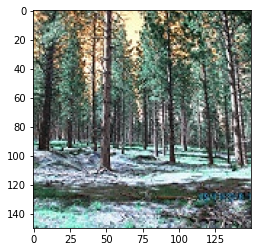

In [55]:
# view image

import matplotlib.pyplot as plt

plt.imshow(inps[1])

In [56]:
# convert color to rgb as cv2 reads img as bgr

inps = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in inps]
inps

[array([[[ 30,  41,  37],
         [ 59,  71,  61],
         [ 81,  96,  77],
         ...,
         [ 96, 122,  95],
         [ 91, 120,  90],
         [ 94, 123,  93]],
 
        [[ 78,  92,  79],
         [ 54,  69,  50],
         [ 58,  77,  47],
         ...,
         [ 90, 113,  87],
         [ 91, 115,  89],
         [ 80, 104,  78]],
 
        [[ 42,  61,  29],
         [ 34,  56,  18],
         [ 74, 100,  52],
         ...,
         [ 93, 106,  88],
         [ 98, 113,  94],
         [ 94, 109,  90]],
 
        ...,
 
        [[124, 117, 111],
         [125, 118, 112],
         [106, 101,  97],
         ...,
         [116, 111, 108],
         [134, 125, 126],
         [ 92,  86,  86]],
 
        [[100,  92,  89],
         [103,  95,  92],
         [109, 104, 101],
         ...,
         [109, 101,  99],
         [127, 117, 118],
         [102,  93,  94]],
 
        [[133, 125, 122],
         [144, 136, 133],
         [137, 132, 129],
         ...,
         [155, 145, 144],
  

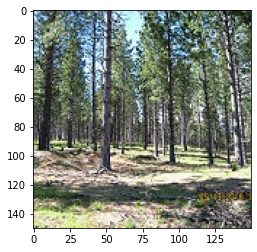

In [57]:
plt.imshow(inps[1])

In [58]:
# convert to array

inps = np.array(inps)

inps.shape

(2, 150, 150, 3)

In [23]:
# install tflite_runtime

!pip install tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 14.1 MB/s 


In [59]:
# extract model from tensorflowlite

import tflite_runtime.interpreter as tflite

model = tflite.Interpreter("model.tflite")

model

In [60]:
# confirm model input details

model.allocate_tensors()

input_details = model.get_input_details()

input_details

[{'name': 'serving_default_sequential_3_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3], dtype=int32),
  'shape_signature': array([ -1, 150, 150,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [61]:
# confirm model output details

output_details = model.get_output_details()

output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 182,
  'shape': array([1, 6], dtype=int32),
  'shape_signature': array([-1,  6], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [35]:
# function for class predictions

def model_predict(images_arr):
    predictions = [0] * len(images_arr)

    for i, val in enumerate(predictions):
        model.set_tensor(input_details[0]['index'], images_arr[i].reshape((1, 150, 150, 3)))
        model.invoke()
        predictions[i] = model.get_tensor(output_details[0]['index']).reshape((6,))
    
    prediction_probabilities = np.array(predictions)
    argmaxs = np.argmax(prediction_probabilities, axis=1)

    return argmaxs

In [39]:
class_mapping

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [38]:
[class_mapping[i] for i in model_predict(inps.astype(np.float32))]

['forest', 'forest']